## 7.5 LSTM

- RNN은 '기울기가 사라지는 기울기 소멸 문제'가 있음
- 해결 위해 LSTM이나 GRU 같은 확장된 RNN 방식들을 사용

### 7.5.1 LSTM 구조
- LSTM 순전파 : 망각 게이트, 입력 게이트, 출력 게이트라는 새로운 요소를 은닉층의 각 뉴런에 추가함.
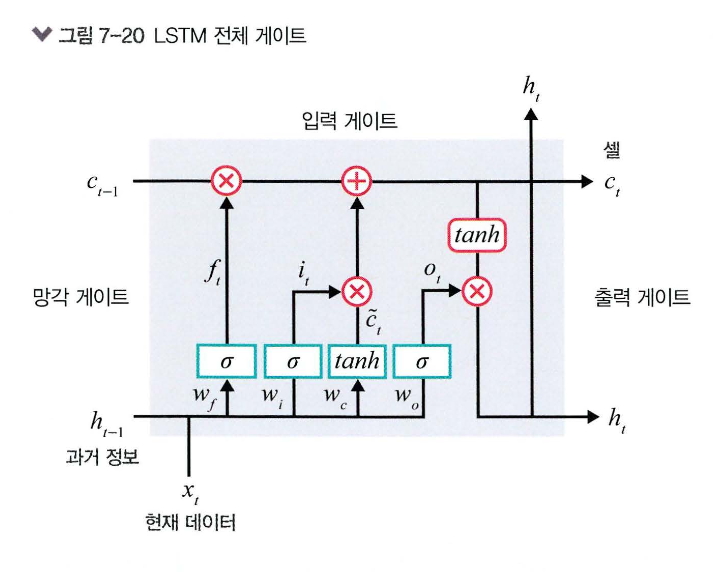
  - 망각 게이트: 과거 정보를 어느 정도 기억할지 결정함.
    - 계산한 값이 1이면 바로 직전의 정보를 메모리에 유지
    - 계산한 값이 0이면 초기화
  - 입력 게이트 : 현재 정보를 기억하기 위해 만들어짐.
    - 계산한 값이 1이면 입력 Xt가 들어올 수 있도록 허용
    - 계산한 값이 0이면 차단
  - 셀: 각 단계에 대한 은닉 노드를 메모리 셀이라고 함. '총합'을 사용해 셀 값을 반영하며, 이것으로 기울기 소멸 문제가 해결됨.
  - 출력 게이트: 과거 정보와 현재 데이터를 사용해 뉴런의 출력을 결정함.
    - 계산한 값이 1이면 의미 있는 결과로 최종 출력
    - 계산한 값이 0이면 해당 연산 출력을 하지 않음.

- LSTM 역전파: LSTM은 셀을 통해 역전파를 수행하기 때문에 '중단 없는 기울기'라고도 함. 최종 오차는 모든 노드에 전파되는데, 이때 셀을 통해 주단 없이 전파됨.
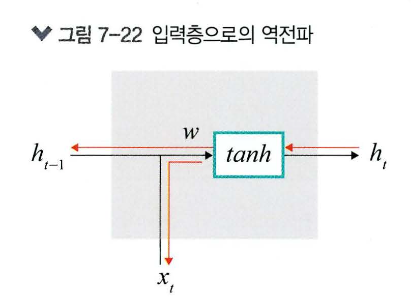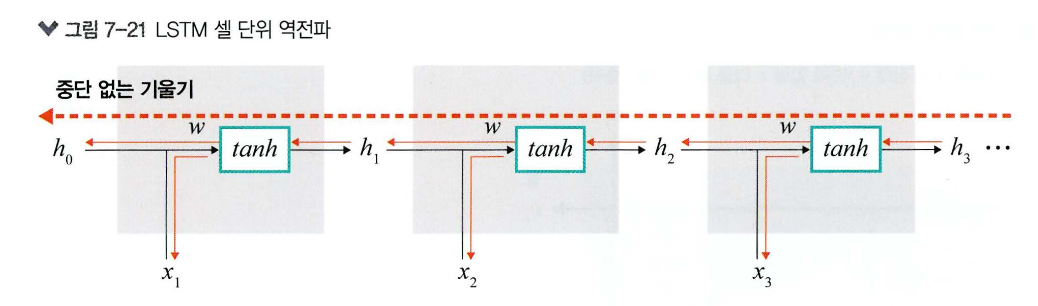

### 7.5.2 LSTM 셀 구현

In [1]:
# 라이브러리 호출
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cude:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(125)

In [19]:
# 데이터 전처리
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

In [52]:
# 데이터셋 내려받기
from torchvision.datasets import MNIST

download_root = ('/content/drive/MyDrive/dnn/chap07/MNIST_DATASET')

train_dataset = MNIST(download_root, transform=mnist_transform, train=True,
                      download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False,
                      download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False,
                      download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 123MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 28.7MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 56.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.55MB/s]


파라미터
- 첫 번째 파라미터: MNIST를 내려받을 위치 지정
- transform: 앞에서 정의했던 데이터 전처리 적용
- train: True로 설정할 경우 훈련용 데이터셋을 가져오지만, False로 설정할 경우 테스트용 데이터셋을 가져옴.
- download: True로 설정될 경우 내려받으려는 위치에 MNIST 파일이 없으면 내려받지만 파일이 있다면 내려받지 않음.

In [53]:
# 데이터셋을 메모리로 가져오기
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [54]:
# 변수 값 지정
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [59]:
# LSTM 셀 네트워크 구축
class LSTMCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super(LSTMCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias)
    self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias)
    self.reset_parameters()


  def reset_parameters(self): # 모델의 파라미터 초기화
      std = 1.0 / math.sqrt(self.hidden_size)
      for w in self.parameters():
        w.data.uniform_(-std, std)

  def forward(self, x, hidden):
      hx, cx = hidden
      x = x.view(-1, x.size(1))

      gates = self.x2h(x) + self.h2h(hx)
      gates = gates.squeeze()
      ingate, forgetgate, cellgate, outgate = gates.chunk(4,1)

      ingates = F.sigmoid(ingate) # 입력 게이트에 시그모이드 활성화 함수 적용
      forgates = F.sigmoid(forgetgate) # 망각 게이트에 시그모이드 활성화 함수 적용
      cellgate = F.tanh(cellgate) # 셀 게이트에 탄젠트 활성화 함수 적용
      outgate = F.sigmoid(outgate) # 출력 게이트에 시그모이드 활성화 함수 적용

      cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
      hy = torch.mul(outgate, F.tanh(cy))

      return(hy, cy)


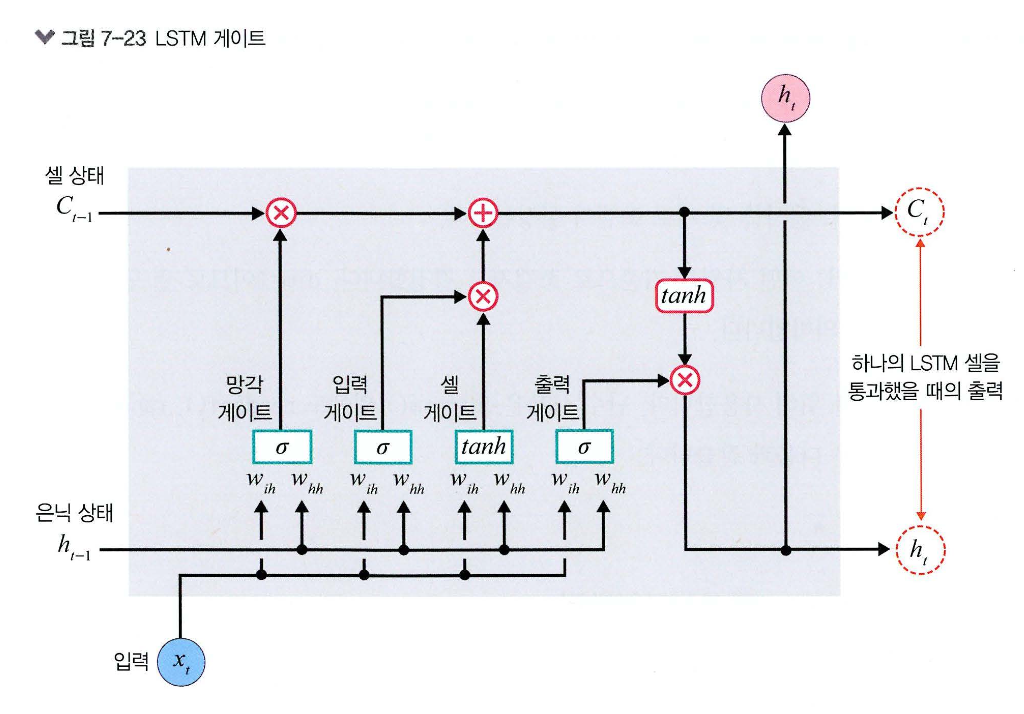

- 게이트는 망각, 입력, 셀, 출력으로 구성됨
- gates = F.linear(input, w_th, b_ih) + F.linear(hx, w_hh, b_hh)
  - input: 입력층으로 입력되는 훈련 데이터셋의 특성 수(칼럼 개수)
  - w_th: 입력층과 은닉층 사이의 가중치
  - b_ih: 입력층과 은닉층 사이의 바이어스
  - hx: 은닉층의 뉴런/유닛 개수(은닉층의 특성 수)
  - w_hh: 은닉층과 은닉층 사이의 가중치
  - b_hh: 은닉층과 은닉층 사이의 바이어스

- ingate, forgetgate, cellgate, outgate = gates.chunk(4,1)
  - 첫 번째 파라미터: 텐서를 몇 개로 쪼갤지 설정함
  - 두 번째 파라미터: 어떤 차원을 기준으로 쪼갤지를 결정함. dim=1이므로 열 단위로 텐서를 분할하겠다는 의미

- uniform(): 난수 사용, 그 외에도 randint(), random() 등이 있음
- torch.squeeze(): 텐서의 차원을 줄이고자 할 때 사용.

In [60]:
# LSTM 셀의 전반적인 네트워크
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
      super(LSTMModel, self).__init__()
      self.hidden_dim = hidden_dim # 은닉층의 뉴런/유닛 개수

      self.layer_dim = layer_dim
      self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
      self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
      if torch.cuda.is_available(): # GPU 사용 유무 확인
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
      else:
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

      if torch.cuda.is_available(): # GPU 사용 유무 확인
        c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
      else:
        c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

      outs = []
      cn = c0[0,:,:] # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 셀 상태에 대한 텐서
      hn = h0[0,:,:] # (은닉층의 계층 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 은닉 상태에 대한 텐서

      for seq in range(x.size(1)): # LSTM 셀 계층을 반복하여 쌓아 올림
        hn, cn = self.lstm(x[:, seq, :], (hn,cn)) # 은닉 상태(hn)와 셀 상태를 LSTMCell에 적용한 결과를 도다시 hn, cn에 저장
        outs.append(hn)

      out = outs[-1].squeeze()
      out = self.fc(out)
      return out

In [61]:
# 옵티마이저와 손실 함수 지정
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available():
  model.cude()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [62]:
# 모델 학습 및 성능 확인
seq_dim = 28
loss_list = []
iter = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        if torch.cuda.is_available():
            images = images.view(-1, seq_dim, input_dim).cuda()
            labels = labels.cuda()
        else:
            images = images.view(-1, seq_dim, input_dim)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0

            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images = images.view(-1, seq_dim, input_dim).cuda()
                    labels = labels.cuda()
                else:
                    images = images.view(-1, seq_dim, input_dim)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()  # cpu() 불필요

            accuracy = 100 * correct / total
            print(f'Iteration: {iter}. Loss: {loss.item():.4f}. Accuracy: {accuracy:.2f}%')

Iteration: 500. Loss: 2.3000. Accuracy: 11.35%
Iteration: 1000. Loss: 2.2966. Accuracy: 11.35%
Iteration: 1500. Loss: 2.3070. Accuracy: 11.35%
Iteration: 2000. Loss: 2.2919. Accuracy: 11.64%
Iteration: 2500. Loss: 2.2954. Accuracy: 12.19%
Iteration: 3000. Loss: 2.2641. Accuracy: 12.31%
Iteration: 3500. Loss: 2.3218. Accuracy: 19.54%
Iteration: 4000. Loss: nan. Accuracy: 9.80%
Iteration: 4500. Loss: nan. Accuracy: 9.80%
Iteration: 5000. Loss: nan. Accuracy: 9.80%
Iteration: 5500. Loss: nan. Accuracy: 9.80%
Iteration: 6000. Loss: nan. Accuracy: 9.80%
Iteration: 6500. Loss: nan. Accuracy: 9.80%
Iteration: 7000. Loss: nan. Accuracy: 9.80%
Iteration: 7500. Loss: nan. Accuracy: 9.80%
Iteration: 8000. Loss: nan. Accuracy: 9.80%
Iteration: 8500. Loss: nan. Accuracy: 9.80%
Iteration: 9000. Loss: nan. Accuracy: 9.80%


In [63]:
# 테스트 데이터셋을 이용한 모델 예측 성능 확인
def evaluate(model, val_iter):
  corrects, total, total_loss = 0, 0, 0
  model.eval()
  for images, labels in val_iter:
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
      labels = lables.cude()
    else:
      images = Variable(images.view(-1, seq_dim, input_dim)).to(device)
      labels = labels.to(device)

    logit = model(images).to(device)
    loss = F.cross_entropy(logit, labels, reduction="sum")
    _, predicted = torch.max(logit.data, 1)
    total += labels.size(0)
    total_loss += loss.item()
    corrects += (predicted == labels).sum()

  avg_loss = total_loss / len(val_iter.dataset)
  avg_accuracy = corrects / total
  return avg_loss, avg_accuracy

In [64]:
# 모델 예측 성능 확인
test_loss, test_acc = evaluate(model, test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:   nan | Test Accuracy:  0.10


### 7.5.3 LSTM 계층 구현

In [65]:
# 라이브러리 호출
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
# 데이터셋 가져오기
data = pd.read_csv('/content/drive/MyDrive/dnn/chap07/data/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [69]:
# 날짜 칼럼을 인덱스로 사용
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [71]:
# 데이터 형식 변경
data['Volume'] = data['Volume'].astype(float)

In [72]:
# 훈련과 레이블 분리
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [74]:
# 데이터 분포 조정
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [76]:
# 데이터셋의 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                    1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                  1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [79]:
# LSTM 네트워크
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
      super(LSTM, self).__init__()
      self.num_classes = num_classes
      self.num_layers = num_layers
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.seq_length = seq_length

      self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                          num_layers = num_layers, batch_first = True)
      self.fc_1 = nn.Linear(hidden_size, 128)
      self.fc = nn.Linear(128, num_classes)
      self.relu = nn.ReLU()

  def forward(self,x):
      h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
      c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
      outputs, (hn, cn) = self.lstm(x, (h_0, c_0))
      hn = hn.view(-1, self.hidden_size)
      out = self.relu(hn)
      out = self.fc_1(out)
      out = self.relu(out)
      out = self.fc(out)
      return out

In [80]:
# 변수 값 설정
num_epochs = 1000
learning_rate = 0.001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [83]:
# 모델 학습
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()
  loss = criterion(outputs, y_train_tensors)
  loss.backward()

  optimizer.step()
  if epoch & 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05380
Epoch: 1, loss: 0.04796
Epoch: 2, loss: 0.04367
Epoch: 3, loss: 0.04090
Epoch: 8, loss: 0.04159
Epoch: 9, loss: 0.04230
Epoch: 10, loss: 0.04262
Epoch: 11, loss: 0.04254
Epoch: 16, loss: 0.03966
Epoch: 17, loss: 0.03932
Epoch: 18, loss: 0.03917
Epoch: 19, loss: 0.03919
Epoch: 24, loss: 0.03994
Epoch: 25, loss: 0.03990
Epoch: 26, loss: 0.03978
Epoch: 27, loss: 0.03961
Epoch: 128, loss: 0.02259
Epoch: 129, loss: 0.02249
Epoch: 130, loss: 0.02239
Epoch: 131, loss: 0.02230
Epoch: 136, loss: 0.02192
Epoch: 137, loss: 0.02185
Epoch: 138, loss: 0.02177
Epoch: 139, loss: 0.02170
Epoch: 144, loss: 0.02140
Epoch: 145, loss: 0.02134
Epoch: 146, loss: 0.02128
Epoch: 147, loss: 0.02123
Epoch: 152, loss: 0.02105
Epoch: 153, loss: 0.02102
Epoch: 154, loss: 0.02099
Epoch: 155, loss: 0.02096
Epoch: 256, loss: 0.02018
Epoch: 257, loss: 0.02017
Epoch: 258, loss: 0.02017
Epoch: 259, loss: 0.02017
Epoch: 264, loss: 0.02015
Epoch: 265, loss: 0.02014
Epoch: 266, loss: 0.02014
Epoch: 2

In [84]:
# 모델 예측 결과를 출력하기 위한 데이터 크기 재구성
df_x_ss = ss.transform(data.iloc[:,:-1])
df_y_ms = ms.transform(data.iloc[:,-1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

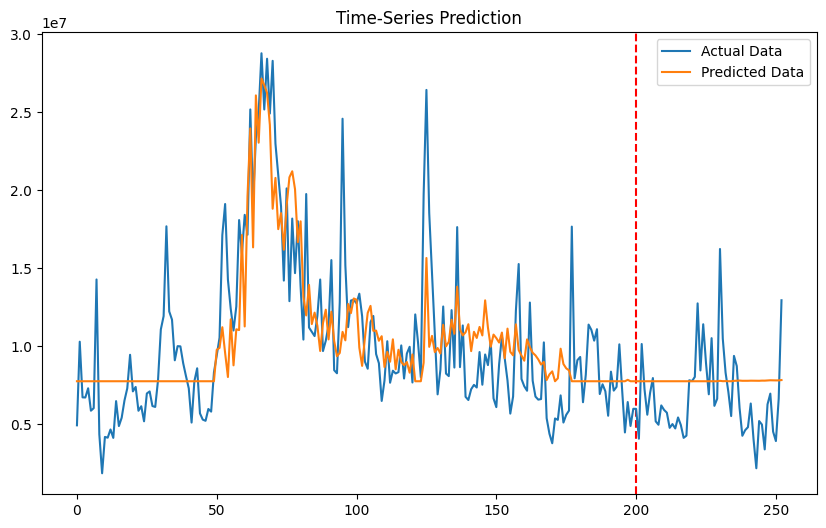

In [86]:
# 모델 예측 결과 출력
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()